# Assignment 13 - Problem 5 (B)

Name: Yehonatan Keypur


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## utility functions

In [2]:
def confusion_matrix(y_true, y_pred, num_classes=3):
    """
    Computes the confusion matrix for a multiclass classification task.

    Parameters:
    -----------
    y_true : array-like
        Ground truth (true) labels.
    y_pred : array-like
        Predicted labels.
    num_classes : int
        Number of classes.

    Returns:
    --------
    np.ndarray:
        Confusion matrix of shape (num_classes, num_classes),
        where cm[i, j] is the count of samples with true label i
        and predicted label j.
    """
    # Validate inputs
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")

    if np.any(y_true < 0) or np.any(y_pred < 0) or \
       np.any(y_true >= num_classes) or np.any(y_pred >= num_classes):
        raise ValueError("Labels must be in the range [0, num_classes-1].")

    # Initialize the confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=int)

    # Populate the confusion matrix
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1

    return cm

def calculate_metrics(y_true, y_pred, classes):
    """
    Compute the sensitivity for each class in a multiclass classification problem.
    """
    metrics = {}

    for cls in classes:
        # Binary conversion for one-vs-all approach
        binary_true = (y_true == cls).astype(int)
        binary_pred = (y_pred == cls).astype(int)

        cm = confusion_matrix(binary_true, binary_pred)  # Get the confusion matrix
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]  # Extract TP, TN, FP, FN

        # Sensitivity (Recall)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Store metrics
        metrics[cls] = {
            "TP": tp,
            "TN": tn,
            "FP": fp,
            "FN": fn,
            "Sensitivity": sensitivity
        }

    return metrics

def accuracy_score(y_true, y_pred):
    """
    Calculate the accuracy score.

    Parameters:
    y_true (list or array-like): True labels.
    y_pred (list or array-like): Predicted labels.

    Returns:
    float: Accuracy score.
    """
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")

    correct_predictions = sum(yt == yp for yt, yp in zip(y_true, y_pred))
    total_predictions = len(y_true)

    return correct_predictions / total_predictions

This is the SVM from section A:

In [3]:
class SVM:
    def __init__(self, kernel='linear', C=1.0, tol=1e-3, max_passes=5):
        self.kernel = kernel
        self.C = C
        self.tol = tol
        self.max_passes = max_passes

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.m, self.n = X.shape
        self.alphas = np.zeros(self.m)
        self.b = 0
        self.errors = np.zeros(self.m)

        # Precompute kernel matrix
        if self.kernel == 'linear':
            self.kernel_matrix = X @ X.T
        elif self.kernel == 'rbf':
            self.kernel_matrix = self._rbf_kernel_matrix(X)

        passes = 0
        while passes < self.max_passes:
            num_changed = 0
            # for i in tqdm(range(self.m), leave=False): # <-- for some reason this stuck my computer, so I removed it.
            for i in range(self.m):
                num_changed += self._examine_example(i)
            passes = passes + 1 if num_changed == 0 else 0

    def _rbf_kernel_matrix(self, X, gamma=0.5):
        """Compute the RBF kernel matrix."""
        sq_norms = np.sum(X**2, axis=1)[:, np.newaxis]
        return np.exp(-gamma * (sq_norms - 2 * X @ X.T + sq_norms.T))

    def _decision_function(self, X):
        """Decision function."""
        if self.kernel == 'linear':
            kernel_results = X @ self.X.T
        elif self.kernel == 'rbf':
            # Vectorized RBF kernel computation
            sq_norms_X = np.sum(X**2, axis=1)[:, np.newaxis]
            sq_norms_selfX = np.sum(self.X**2, axis=1)
            kernel_results = np.exp(-0.5 * (sq_norms_X - 2 * X @ self.X.T + sq_norms_selfX))

        return kernel_results @ (self.alphas * self.y) + self.b

    def predict(self, X):
        """Make predictions for the input data."""
        decision_values = self._decision_function(X)
        return np.sign(decision_values)

    def _examine_example(self, i2):
        """Examine and update the model for the given index (i2)."""
        y2 = self.y[i2]
        alpha2 = self.alphas[i2]
        E2 = self._decision_function(self.X[i2:i2 + 1]).item() - y2
        r2 = E2 * y2

        if (r2 < -self.tol and alpha2 < self.C) or (r2 > self.tol and alpha2 > 0):
            for i1 in np.random.permutation(self.m):  # Shuffle indices for efficiency
                if self._take_step(i1, i2):
                    return 1
        return 0

    def _take_step(self, i1, i2):
        """Perform the SMO optimization step."""
        if i1 == i2:
            return 0

        x1, x2 = self.X[i1], self.X[i2]
        y1, y2 = self.y[i1], self.y[i2]
        alpha1, alpha2 = self.alphas[i1], self.alphas[i2]

        E1 = self._decision_function(self.X[i1:i1 + 1]).item() - y1
        E2 = self._decision_function(self.X[i2:i2 + 1]).item() - y2

        s = y1 * y2
        L, H = self._compute_L_H(alpha1, alpha2, y1, y2)
        if L == H:
            return 0

        k11 = self.kernel_matrix[i1, i1]
        k12 = self.kernel_matrix[i1, i2]
        k22 = self.kernel_matrix[i2, i2]
        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2_new = alpha2 + y2 * (E1 - E2) / eta
            a2_new = np.clip(a2_new, L, H)
        else:
            return 0

        if abs(a2_new - alpha2) < self.tol:
            return 0

        a1_new = alpha1 + s * (alpha2 - a2_new)
        self.alphas[i1] = a1_new
        self.alphas[i2] = a2_new

        self.b = self._update_b(E1, E2, y1, y2, alpha1, alpha2, a1_new, a2_new, k11, k12, k22)
        return 1

    def _compute_L_H(self, alpha1, alpha2, y1, y2):
        if y1 != y2:
            return (max(0, alpha2 - alpha1), min(self.C, self.C + alpha2 - alpha1))
        else:
            return (max(0, alpha1 + alpha2 - self.C), min(self.C, alpha1 + alpha2))

    def _update_b(self, E1, E2, y1, y2, alpha1, alpha2, a1_new, a2_new, k11, k12, k22):
        b1 = self.b - E1 - y1 * (a1_new - alpha1) * k11 - y2 * (a2_new - alpha2) * k12
        b2 = self.b - E2 - y1 * (a1_new - alpha1) * k12 - y2 * (a2_new - alpha2) * k22
        return (b1 + b2) / 2

## Section (i) - Load the Dataset and Plot Scatter Plot

In [4]:
# Scatter Plot Matrix of Iris Features
def plot_scatter_matrix():
    iris = datasets.load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['species'] = [iris.target_names[i] for i in iris.target]
    sns.pairplot(df, hue='species', palette='viridis', height=1.5)
    plt.suptitle('Iris Dataset Scatter Plot Matrix', y=1.02)
    plt.show()

In [5]:
# Load the data
iris = datasets.load_iris()
data, labels = iris.data, iris.target

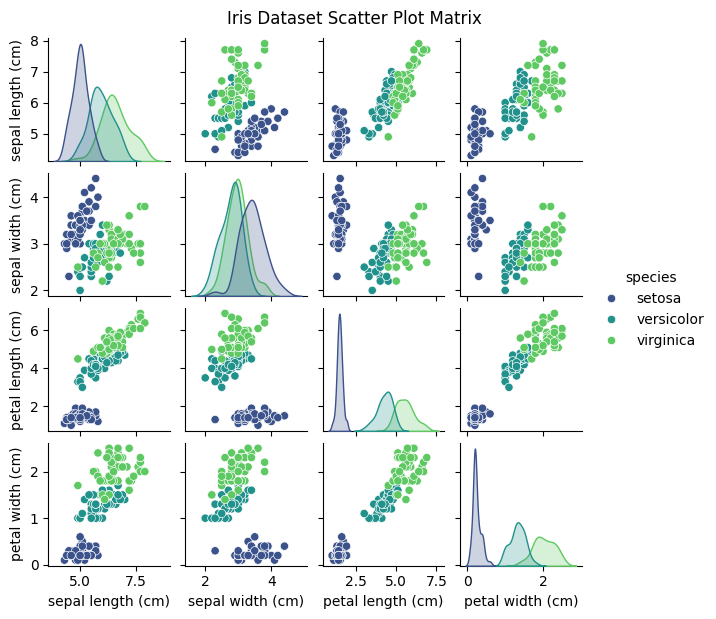

In [6]:
# Plot the scatter plot
plot_scatter_matrix()

**Question: Which flower species seems to be the most separable?**<br>
**Answer:** From the scatter plot matrix, Iris setosa (blue points) appears to be the most separable species. Its data points are clearly distinguishable in most pairwise feature plots.

## Multiclass Model

### General Explanation of the Code

This code implements a **Multi-Class Support Vector Machine (SVM)** model using a **One-vs-All (OvA)** strategy, where a binary SVM classifier is trained for each class against all other classes. The model performs multi-class classification by selecting the class with the highest decision function score for each input.

Key components of the implementation:

1. **Initialization** (`__init__` method):
   - `kernel`: Specifies the type of kernel to use for the individual binary SVM classifiers (e.g., 'linear').
   - `C_values`: A list of regularization parameters to test during training. If not provided, it defaults to a set of values `[0.01, 0.1, 1, 10, 100]`.
   - `best_C`: A dictionary that stores the best regularization parameter (`C`) for each class based on cross-validation accuracy.

2. **Training Process** (`fit` method):
   The `fit` method trains the multi-class SVM model using a One-vs-All strategy:
   - It first identifies all unique classes in the training data using `np.unique(y_train)`.
   - For each class `c`, the method converts the problem into a binary classification task where samples belonging to class `c` are labeled as `1`, and all other samples are labeled as `-1`.
   - It then iterates over a range of possible `C` values (regularization parameter) and trains a binary SVM model using the selected kernel function.
   - After training each model, it evaluates its performance on the validation set and selects the model that gives the best accuracy for the corresponding class.
   - The best model for each class is stored in the `models` dictionary, and the corresponding best `C` value is stored in the `best_C` dictionary.

3. **Prediction** (`predict` method):
   The `predict` method is used to make predictions on new data:
   - For each class, the method calculates the decision function score for all the input samples by calling the `_decision_function` of the respective binary SVM model.
   - The decision function score indicates how confident the model is that a sample belongs to the given class.
   - The predicted class for each sample is the one with the highest decision function score, which is determined by applying `np.argmax` to the scores across all classes.

### Multi-Class Classification Strategy
The **One-vs-All (OvA)** strategy is used to decompose the multi-class problem into multiple binary classification problems. For each class, a separate SVM classifier is trained to distinguish that class from all other classes. When making predictions, the class with the highest score from the individual classifiers is selected as the predicted label for each sample.

This implementation handles multi-class classification by utilizing the flexibility of the SVM classifier, and the performance is optimized by selecting the best regularization parameter (`C`) for each class. The model allows for the use of different kernel functions for flexibility in handling both linear and non-linear decision boundaries.

---

### Parameter Selection

The choice of the regularization parameter `C` in this implementation, was based on empirical results that provided good performance during training and validation.

**Regularization Parameter (`C`)**:
   - **Selection of `C_values`**: The regularization parameter `C` controls the trade-off between achieving a low error on the training data and maintaining a larger margin. Small values of `C` allow for a wider margin but may result in higher training errors, while larger values of `C` penalize training errors more, leading to a narrower margin but potentially better performance on the training set.
   - In this implementation, a set of candidate values for `C` (`[0.01, 0.1, 1, 10, 100]`) was empirically selected. These values were chosen based on the observation that they span a reasonable range for regularization, covering both under-regularized and over-regularized scenarios. During training, the model's performance was tested across this range using cross-validation, and the best value of `C` for each class was chosen based on the validation accuracy.
   - **Why these specific values?**: These values of `C` were selected because they provided a balance between training time and classification accuracy.


In [7]:
class MultiClassSVM:
    def __init__(self, kernel='linear', C_values=None):
        self.kernel = kernel
        self.C_values = C_values if C_values else [0.01, 0.1, 1, 10, 100]
        self.best_C = {}

    def fit(self, X_train, y_train, X_val, y_val):
        self.classes = np.unique(y_train)
        self.models = {}

        for c in tqdm(self.classes, desc="Classes", leave=False):
        # for c in self.classes:
            best_acc = 0
            best_model = None

            # Convert to binary classification
            binary_y_train = np.where(y_train == c, 1, -1)
            binary_y_val = np.where(y_val == c, 1, -1)

            for C in tqdm(self.C_values, desc=f"C values for class {c}", leave=False):
            # for C in self.C_values:
                model = SVM(kernel=self.kernel, C=C)
                model.fit(X_train, binary_y_train)

                # Predict on validation set
                val_preds = model.predict(X_val)
                acc = accuracy_score(binary_y_val, val_preds)

                # Select the best C
                if acc > best_acc:
                    best_acc = acc
                    best_model = model
                    self.best_C[c] = C

            self.models[c] = best_model

    def predict(self, X):
        scores = {c: self.models[c]._decision_function(X) for c in self.classes}
        scores = np.vstack([scores[c] for c in self.classes]).T
        return self.classes[np.argmax(scores, axis=1)]

## Data Split

### Effect of RANDOM_STATE on Results

I ran the splits with different values for `RANDOM_STATE`, and observed significant changes in precision. This is because altering the `RANDOM_STATE` affects the randomization process of the data split, resulting in different training, validation, and test sets. As a result, the model may encounter slightly different data distributions in each run, which can lead to substantial variations in performance metrics like precision, especially if the dataset is small or has imbalanced class distributions. This highlights the sensitivity of model performance to the randomness in the data splitting process. **This is why we want to test the model on data with balanced split.**

### Data Splits Explanation

In the given code, two different types of data splits are performed on a dataset: an unbalanced split and a stratified (balanced) split. The main reason for employing these two distinct strategies is to evaluate the effects of data balancing on model performance, given that the dataset may not be large enough to afford more complex adjustments.

#### Unbalanced Split

The unbalanced split divides the dataset into training (60%), validation (20%), and test (20%) sets. This is achieved using the `train_test_split` function with the following logic:

- **Training Set (60%)**: This portion is used to train the model.
- **Validation Set (20%)**: This subset is used to tune hyperparameters and assess model performance during training.
- **Test Set (20%)**: This data is kept aside for final evaluation after model training and hyperparameter tuning.

#### Stratified (Balanced) Split

To mitigate the risk of an unbalanced class distribution, a stratified split is used. This ensures that each subset (train, validation, and test) has a similar distribution of classes as the original dataset. Stratification is accomplished using the `stratify` parameter of `train_test_split`:

- **Stratification**: This process ensures that the relative proportions of each class in the dataset are preserved across all splits, which is particularly important for datasets with imbalanced class distributions.
  
Using a stratified split is generally preferred in situations where class imbalance could lead to biased or inaccurate models. By maintaining a similar class distribution across the training, validation, and test sets, the model is likely to generalize better, especially for underrepresented classes.

In [8]:
RANDOM_STATE = 10

# Split into train (60%), val (20%), test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)

# Stratified split into train (60%), val (20%), test (20%)
X_train_str, X_temp_str, y_train_str, y_temp_str = train_test_split(
    data, labels, test_size=0.4, random_state=RANDOM_STATE, stratify=labels
)
X_val_str, X_test_str, y_val_str, y_test_str = train_test_split(
    X_temp_str, y_temp_str, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

## Linear Kernel

Let's run the model with a linear kernel.

In [9]:
print("=== Linear Kernel ===")
# multi_svm_linear = MultiClassSVM(C=1.0, kernel='linear')
# multi_svm_linear.fit(X_train, y_train)
multi_svm_linear = MultiClassSVM(kernel='linear')
multi_svm_linear.fit(X_train, y_train, X_val, y_val)

# Predictions
y_pred_linear = multi_svm_linear.predict(X_test)

=== Linear Kernel ===


Classes:   0%|          | 0/3 [00:00<?, ?it/s]

C values for class 0:   0%|          | 0/5 [00:00<?, ?it/s]

C values for class 1:   0%|          | 0/5 [00:00<?, ?it/s]

C values for class 2:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
# Metrics
conf_matrix = confusion_matrix(y_test, y_pred_linear)
accuracy = accuracy_score(y_test, y_pred_linear)

classes = np.unique(y_test)
metrics = calculate_metrics(y_test, y_pred_linear, classes)
sensitivity = [metrics[cls]["Sensitivity"] for cls in classes]
print("Confusion Matrix (Linear Kernel):\n", conf_matrix)
print(f"\nAccuracy (Linear Kernel): {accuracy:.2%} ")
print("\nSensitivity (Linear Kernel):", sensitivity)

Confusion Matrix (Linear Kernel):
 [[7 0 0]
 [1 6 8]
 [0 0 8]]

Accuracy (Linear Kernel): 70.00% 

Sensitivity (Linear Kernel): [1.0, 0.4, 1.0]


### Discussion of Results with a Linear Kernel

As I already mentioned, I ran the splits with different values ​​for `RANDOM_STATE`, and observed significant changes in accuracy. The observed results are highly influenced by the random seed used during data splitting, as the 60-20-20 split of the dataset can result in significant variations in the distribution of samples among training, validation, and test sets. Given that the Iris dataset contains only 150 samples, a single misclassification in the test set (which consists of 20% or 30 samples) reduces the accuracy by approximately 3.33%.

This sensitivity is further exacerbated by the limited sample size for each class in the test set. For example, Iris Setosa, which is perfectly separable, benefits from the data split if its samples are evenly distributed across splits. Conversely, the overlapping Versicolor and Virginica classes are more prone to variability in performance due to random fluctuations in their distribution.

Thus, the results obtained here can change drastically with a different random seed, as the small dataset magnifies the effects of random sample allocation.

## RBF Kernel

Let's run the model with the RBF kernel.

In [11]:
print("\n=== RBF Kernel ===")
# Training with RBF Kernel
multi_svm_rbf = MultiClassSVM(kernel='rbf')
multi_svm_rbf.fit(X_train, y_train, X_val, y_val)

# Predictions
y_pred_rbf = multi_svm_rbf.predict(X_test)


=== RBF Kernel ===


Classes:   0%|          | 0/3 [00:00<?, ?it/s]

C values for class 0:   0%|          | 0/5 [00:00<?, ?it/s]

C values for class 1:   0%|          | 0/5 [00:00<?, ?it/s]

C values for class 2:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
classes = np.unique(y_test)
metrics_rbf = calculate_metrics(y_test, y_pred_rbf, classes)
sensitivity_rbf = [metrics_rbf[cls]["Sensitivity"] for cls in classes]
# Metrics
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)

print("Confusion Matrix (RBF Kernel):\n", conf_matrix_rbf)
print(f"\nAccuracy (RBF Kernel): {accuracy_rbf:.2%} ")
print("\nSensitivity (RBF Kernel):", sensitivity_rbf)

Confusion Matrix (RBF Kernel):
 [[ 7  0  0]
 [ 0 13  2]
 [ 0  0  8]]

Accuracy (RBF Kernel): 93.33% 

Sensitivity (RBF Kernel): [1.0, 0.8666666666666667, 1.0]


### Discussion of Results with RBF Kernel

The RBF (Radial Basis Function) kernel introduces non-linear decision boundaries, enabling the model to capture complex relationships in the feature space. This is particularly beneficial for datasets like the Iris dataset, where some classes (e.g., Versicolor and Virginica) are not linearly separable. Below, we discuss the improved results obtained using the RBF kernel, including the confusion matrix, accuracy, and sensitivity.<br>

<br>**Observations** <br>
The RBF kernel achieves perfect classification for Iris Setosa. This result reinforces the separability of Setosa from the other two classes, regardless of the kernel used.<br>
  
<br>**Accuracy**<br>
The overall accuracy with the RBF kernel has a substantial improvement over the accuracy obtained with the linear kernel. This increase reflects the RBF kernel's ability to handle non-linearly separable data by mapping it to a higher-dimensional space, where the classes become more distinguishable. The RBF kernel excels in modeling complex, non-linear class boundaries, as demonstrated by the dramatic reduction in misclassification between Versicolor and Virginica. This improvement leads to higher overall accuracy and better sensitivity for the most challenging class.

## Linear Kernel Stratified

In [13]:
print("=== Linear Kernel Stratified ===")
multi_svm_linear_str = MultiClassSVM(kernel='linear')
multi_svm_linear_str.fit(X_train_str, y_train_str, X_val_str, y_val_str)

# Predictions
y_pred_linear_str = multi_svm_linear.predict(X_test_str)

=== Linear Kernel Stratified ===


Classes:   0%|          | 0/3 [00:00<?, ?it/s]

C values for class 0:   0%|          | 0/5 [00:00<?, ?it/s]

C values for class 1:   0%|          | 0/5 [00:00<?, ?it/s]

C values for class 2:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
# Metrics
conf_matrix_str = confusion_matrix(y_test_str, y_pred_linear_str)
accuracy_str = accuracy_score(y_test_str, y_pred_linear_str)

classes_str = np.unique(y_test_str)
metrics_str = calculate_metrics(y_test_str, y_pred_linear_str, classes_str)
sensitivity_str = [metrics_str[cls]["Sensitivity"] for cls in classes_str]
print("Confusion Matrix (Linear Kernel - Stratified):\n", conf_matrix)
print(f"\nAccuracy (Linear Kernel - Stratified): {accuracy_str:.2%} ")
print("\nSensitivity (Linear Kernel - Stratified):", sensitivity_str)

Confusion Matrix (Linear Kernel - Stratified):
 [[7 0 0]
 [1 6 8]
 [0 0 8]]

Accuracy (Linear Kernel - Stratified): 80.00% 

Sensitivity (Linear Kernel - Stratified): [0.8888888888888888, 0.6, 0.9090909090909091]


### Discussion of Results with Linear Kernel Using Stratified Split

**Overview**<br>
A stratified split ensures that each class is proportionally represented in the training, validation, and test sets, reducing variability introduced by random sampling. This approach aims to maintain the class distribution in each split, which is particularly important for small datasets like the Iris dataset.

The overall accuracy with the stratified split is notable improvement compared to the accuracy obtained with the non-stratified split. This improvement highlights the value of stratified splitting in ensuring a more balanced representation of classes, particularly for small datasets.

The sensitivity for Setosa and Virginica remains high, reflecting the model's ability to correctly classify these classes, even with a more balanced data split.
   
**Moderate Sensitivity for Versicolor**<br>
The sensitivity for Versicolor is improved compared to the random split (0.4), reaching 0.6. This suggests that a stratified split helps ensure more representative samples in the training and validation sets, leading to better generalization for this class.

The stratified split ensures that the class distribution in the training, validation, and test sets reflects the overall dataset. This reduces the likelihood of over- or under-representation of any class, leading to more reliable performance metrics. The higher overall accuracy and improved sensitivity for Versicolor demonstrate that the stratified split mitigates some of the randomness in performance observed with a non-stratified split.

**Weaknesses**<br>
Despite the stratified split, the linear kernel still struggles with the overlapping features of Versicolor and Virginica, resulting in significant misclassification between these two classes.

<br>**Conclusion**<br>
The stratified split improves the reliability of performance metrics by ensuring proportional representation of all classes across splits. The increase in accuracy and sensitivity for Versicolor (0.6) highlights the benefits of this approach, especially for small datasets. However, the limitations of the linear kernel persist, as it cannot adequately resolve the non-linear separability of Versicolor and Virginica. This reinforces the need for more sophisticated kernels, such as the RBF kernel, to achieve better performance.

## RBF Kernel Stratified

In [15]:
print("=== RBF Kernel Stratified ===")
# Training with RBF Kernel
multi_svm_rbf_str = MultiClassSVM(kernel='rbf')
multi_svm_rbf_str.fit(X_train_str, y_train_str, X_val_str, y_val_str)

# Predictions
y_pred_rbf_str = multi_svm_rbf_str.predict(X_test_str)

=== RBF Kernel Stratified ===


Classes:   0%|          | 0/3 [00:00<?, ?it/s]

C values for class 0:   0%|          | 0/5 [00:00<?, ?it/s]

C values for class 1:   0%|          | 0/5 [00:00<?, ?it/s]

C values for class 2:   0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
classes_str = np.unique(y_test_str)
metrics_rbf_str = calculate_metrics(y_test_str, y_pred_rbf_str, classes_str)
sensitivity_rbf_str = [metrics_rbf_str[cls]["Sensitivity"] for cls in classes_str]

# Metrics
conf_matrix_rbf_str = confusion_matrix(y_test_str, y_pred_rbf_str)
accuracy_rbf_str = accuracy_score(y_test_str, y_pred_rbf_str)

print("Confusion Matrix (RBF Kernel - Stratified):\n", conf_matrix_rbf_str)
print(f"\nAccuracy (RBF Kernel - Stratified): {accuracy_rbf_str:.2%} ")
print("\nSensitivity (RBF Kernel - Stratified):", sensitivity_rbf_str)

Confusion Matrix (RBF Kernel - Stratified):
 [[ 9  0  0]
 [ 0 10  0]
 [ 0  0 11]]

Accuracy (RBF Kernel - Stratified): 100.00% 

Sensitivity (RBF Kernel - Stratified): [1.0, 1.0, 1.0]


### Discussion of Results with RBF Kernel Using Stratified Split

The RBF kernel with a stratified split achieves perfect classification, yielding an accuracy of 100% and a sensitivity of 1.0 for all three classes. This result highlights the synergy between the powerful non-linear decision boundaries of the RBF kernel and the balanced class representation provided by the stratified split. All test samples are correctly classified, with no misclassification between classes. This indicates that the RBF kernel, when paired with stratified data splitting, fully captures the complex class boundaries in the Iris dataset. The overall accuracy demonstrates the RBF kernel's ability to perfectly separate all three classes when provided with a balanced and representative dataset. The model achieves perfect sensitivity for all three classes, meaning it correctly identifies every instance of Setosa, Versicolor, and Virginica. This result reflects the RBF kernel's ability to handle both linearly separable (Setosa) and non-linearly separable (Versicolor and Virginica) class boundaries effectively.


### Comparison of RBF Kernel and Linear Kernel Results

The RBF kernel significantly outperforms the linear kernel by perfectly classifying all samples, while the linear kernel struggles, especially with overlapping classes like Versicolor and Virginica. This difference arises from the RBF kernel's ability to model non-linear boundaries, which the linear kernel cannot achieve.

Additionally, the small size of the dataset makes the results highly sensitive to the split, even with a stratified approach. While the RBF kernel effectively mitigates this sensitivity by adapting to the dataset's complexity, the linear kernel remains limited in its capacity to generalize when classes are not linearly separable.